# Multicolineraity, correlations and importance for machine learning applications.
## Contents
1. multicolinearity and how to address it:

    * Multicollinearity is a phenomenon in which one predictor variable in a multiple regression model can be linearly predicted from the others
    * Makes the model unstable
    * Predictive performance does not suffer, but any inference about individual coefficients is flawed

    * analyze a simple dataset and show failure modes for multicolinearity
    * let's predict the width of the fish based on other data
    * I will add a bogous column that is multicollinear with others and show how it affects coefficients

2. measuring correlations with different data types.
    * Cramer's V (categorical, categorical)
    * Theil's U (categorical, categorical)
    * Correlation ratio (categorical, numerical)

In [2]:
# let's predict the width of the fish from other measurements
import pandas as pd
fish = pd.read_csv('datasets-229906-491820-Fish.csv')
fish.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [27]:
# let's use Statsmodels for the analysis to get away from Scikit learn!
import statsmodels.api as sm

# let's ignore categorical features at the moment
X = fish[['Weight', 'Length1', 'Length2', 'Length3', 'Height']]
X = sm.add_constant(X) # this is for the bias term, y = ax+b (b is the constant or bias term)
y = fish['Width']

mod = sm.OLS(y, X)
res = mod.fit()
fish['y_pred_original'] = res.predict(X) # save predictions to the dataframe
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Width   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     348.0
Date:                Tue, 07 Jul 2020   Prob (F-statistic):           1.21e-81
Time:                        17:42:47   Log-Likelihood:                -108.16
No. Observations:                 159   AIC:                             228.3
Df Residuals:                     153   BIC:                             246.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4834      0.194      2.492      0.0

### Notice the high R squared value! Based on low p values the constant term (bias), Length2, Length3 and Height are important features, while Weight and Length1 are not important (also coefficients for Weight and Length1 are tiny).

In [10]:
# let's through in some correlated features
fish['Length4'] = fish['Length3']
fish['Length5'] = fish['Length3']
fish['Length6'] = fish['Length3']

X_cor = fish[['Weight', 'Length1', 'Length2', 'Length3', 'Length4', 'Length5', 'Length6', 'Height']]
X_cor = sm.add_constant(X_cor)
mod = sm.OLS(y, X_cor)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Width   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     348.0
Date:                Tue, 07 Jul 2020   Prob (F-statistic):           1.21e-81
Time:                        16:34:20   Log-Likelihood:                -108.16
No. Observations:                 159   AIC:                             228.3
Df Residuals:                     153   BIC:                             246.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4834      0.194      2.492      0.0

### Oh no, R squared is exactly the same but now we have more important features! Length3, Length4, Length5 and Length6 are all equally important, with smaller coefficiets. -0.137*4 = -0.548 = coefficient for Length3 in the previous model. Based on this model you might conclude that all Lengths except Length1 are important, but actually having Length2 and Length3 is sufficient to predict the width. You can experiment adding multicolinearity to the model, e.g. making a column that is a linear combination of multiple columns, you will see that coefficients and p values will change, and unimportant features might become important, which is why a linear model with multiple colinearitis is unstable and coefficient interpretation is flawed!

## How do you check for correlations?
1. Pearson correlation coefficient
    * Correlation is a technique for investigating the relationship between two quantitative, continuous variables, for example, age and blood pressure. Pearson's correlation coefficient (r) is a measure of the strength of the association between the two variables.
http://learntech.uwe.ac.uk/da/Default.aspx?pageid=1442
2. Variance Inflation Factor (VIF)
    * In statistics, the variance inflation factor (VIF) is the quotient of the variance in a model with multiple terms by the variance of a model with one term alone.[1] It quantifies the severity of multicollinearity in an ordinary least squares regression analysis. 
https://en.wikipedia.org/wiki/Variance_inflation_factor

Text(0.5, 1.0, 'Pearson correlation coefficient between correlated features')

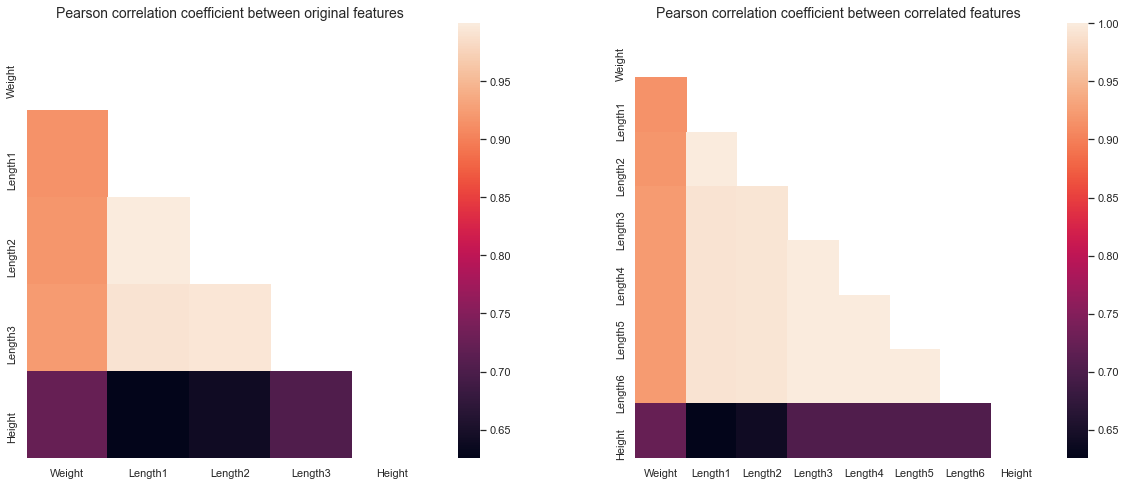

In [12]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# a heatmap is a quick visual representation of correlation
# since Pearson correlation is symmetrical between (x, y) and (y, x), plot one half of the heatmap
corr_mat_original = np.corrcoef(X.drop('const', axis=1).values, rowvar=False)

mask_original = np.triu(np.ones_like(corr_mat_original, dtype=np.bool))
sns.set(style="white")

corr_mat_cor = np.corrcoef(X_cor.drop('const', axis=1).values, rowvar=False)

mask_cor = np.triu(np.ones_like(corr_mat_cor, dtype=np.bool))

# Set up the matplotlib figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(corr_mat_original, annot=False, mask=mask_original, xticklabels=X.drop('const', axis=1).columns, \
            yticklabels=X.drop('const', axis=1).columns, ax=ax1)
ax1.set_title("Pearson correlation coefficient between original features", fontsize=14)

sns.heatmap(corr_mat_cor, annot=False, mask=mask_cor, xticklabels=X_cor.drop('const', axis=1).columns, \
            yticklabels=X_cor.drop('const', axis=1).columns, ax=ax2)
ax2.set_title("Pearson correlation coefficient between correlated features", fontsize=14)


### Actually, even the original dataset has highly correlated features (lowest Pearson correlation ~0.6). As a rule of thumb, correlation >0.7 needs to be dealt with. Let's try fitting a moddel with least correlated features.

In [25]:
X_red = fish[['Length1', 'Height']]
X_red = sm.add_constant(X_red)
mod = sm.OLS(y, X_red)
res = mod.fit()
fish['y_pred_red'] = res.predict(X_red)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Width   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     459.7
Date:                Tue, 07 Jul 2020   Prob (F-statistic):           3.96e-66
Time:                        17:41:38   Log-Likelihood:                -154.66
No. Observations:                 159   AIC:                             315.3
Df Residuals:                     156   BIC:                             324.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2667      0.147      1.809      0.0

## Which model is better?

Notice the R squared went down in the last example, but is still reasonably high. Depending on the business case that might be acceptable trade off for simplicity. There is also a statistical test that tells you if a more complex model is significantly better.

## F test for regression model comparison
1. calculate the F-statistic:
    * F statistic = (RSS1 - RSS2)/(k2-k1)/RSS2/(n-k2), RSS1, RSS2 - sum of squared residual errors for simple and complex model respecively, k1, k2 - number of parameters for simpler and complex model respectively, n - number of samples
2. Determine probability density function (scipy stats):
    * F distribution with d1, d2 degrees of freedom, d1 = k2-k1, d2=n-k2
3. Determine the percentile of the test statistic (or calculate the value of minimal percentile you are willing to reject the null hypothesis).
    
### Reference
https://towardsdatascience.com/fisher-test-for-regression-analysis-1e1687867259

In [31]:
rss_orig = ((fish['y_pred_original'] - fish['Width'])**2).sum() # more complex model
rss_red = ((fish['y_pred_red'] - fish['Width'])**2).sum() # simpler model
print("Residual sum of squares in the original model ", rss_orig)
print("Residual sum of squares in the reduced model ", rss_red)

Residual sum of squares in the original model  36.29077053962928
Residual sum of squares in the reduced model  65.1306781089401


In [33]:
F_stat = ((rss_red - rss_orig)/(6-3))/(rss_orig/(len(fish)-6))
print("F statistic for comparing the original (more complex) and reduced (simpler) models: ", F_stat)

F statistic for comparing the original (more complex) and reduced (simpler) models:  40.52918315494871


Text(0.5, 1.0, 'Probability density function')

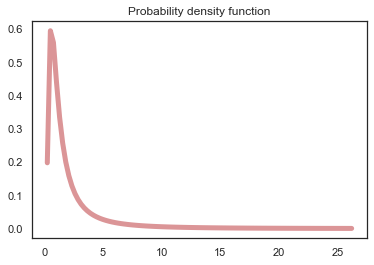

In [42]:
from scipy.stats import f
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
dfn, dfd = len(fish)-6, 6-3
x = np.linspace(f.ppf(0.01, dfn, dfd), 
                f.ppf(0.99, dfn, dfd), 100)
ax.plot(x, f.pdf(x, dfn, dfd), 'r-', lw=5, alpha=0.6, label='f pdf')
plt.title("Probability density function")

In [44]:
# you can see from the plot 40 is way far off to the right
val_099 = f.ppf(0.99, dfn, dfd) # value for 99th percentile
val_099

26.200503580012857

## 40 > 26, hence the more complex model is statistically significanlty better than the reduced model. Perhaps, removing one feature at a time is safer! Note, statsmodels computes an F-statistic and a p value for each model sammary. In this case the simple model is the one with just the bias (constant) term.

In [48]:
# measure variance inflation factor 
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X.drop('const', axis=1).values, i) for i in range(X.drop('const', axis=1).shape[1])]
for (col, vif_val) in zip(X.drop('const', axis=1).columns, vif):
    print(col, vif_val)

Weight 6.731679255535451
Length1 13550.962990048614
Length2 14928.43787744658
Length3 2043.4247034622736
Height 35.815771460035116


In [49]:
vif = [variance_inflation_factor(X_cor.drop('const', axis=1).values, i) for i in range(X_cor.drop('const', axis=1).shape[1])]
for (col, vif_val) in zip(X_cor.drop('const', axis=1).columns, vif):
    print(col, vif_val)

Weight 6.731679255535446
Length1 13550.962990048614
Length2 14928.43787744658
Length3 inf
Length4 inf
Length5 inf
Length6 inf
Height 35.81577146003526


## How to interpret vif values
* 1 = not correlated.
* Between 1 and 5 = moderately correlated.
* Greater than 5 = highly correlated.
    * inf - means perfect multicollinearity

Can systematically remove one feature at a time and repeat the vif calculation

### See "Remedies for multicollinearity" in the Wikipedia article

Refs:
https://www.statisticshowto.com/variance-inflation-factor/
https://en.wikipedia.org/wiki/Multicollinearity

## Wait can't the regularization take care of multicolinearity for me?
* lets try 3 regularization methods

In [53]:

reg_fit_lasso = sm.OLS(y, X_cor).fit_regularized(alpha=0.05, L1_wt=1, refit=True)
print(reg_fit_lasso.summary())

                            OLS Regression Results                            
Dep. Variable:                  Width   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     313.0
Date:                Tue, 07 Jul 2020   Prob (F-statistic):           9.62e-79
Time:                        22:18:59   Log-Likelihood:                -116.36
No. Observations:                 159   AIC:                             244.7
Df Residuals:                     154   BIC:                             263.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5862      0.202      2.904      0.0

In [58]:
# ridge regression not implemented, had to make L1 really small
reg_fit_ridge = sm.OLS(y, X_cor).fit_regularized(alpha=0.05, L1_wt=0.000000000001, refit=True) 
print(reg_fit_ridge.summary())

                            OLS Regression Results                            
Dep. Variable:                  Width   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     247.0
Date:                Tue, 07 Jul 2020   Prob (F-statistic):           1.22e-79
Time:                        22:21:37   Log-Likelihood:                -108.16
No. Observations:                 159   AIC:                             232.3
Df Residuals:                     152   BIC:                             256.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4834      0.195      2.484      0.0

In [59]:
reg_fit_elastic = sm.OLS(y, X_cor).fit_regularized(alpha=0.05, L1_wt=0.5, refit=True) 
print(reg_fit_elastic.summary())

                            OLS Regression Results                            
Dep. Variable:                  Width   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     313.0
Date:                Tue, 07 Jul 2020   Prob (F-statistic):           9.62e-79
Time:                        22:22:56   Log-Likelihood:                -116.36
No. Observations:                 159   AIC:                             244.7
Df Residuals:                     154   BIC:                             263.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5862      0.202      2.904      0.0

## Lasso and elastic net give similar results and can take care of multicolinearity to an extent, ridge regressio (L2) is not well-suited.

## What if you want to measure correlations between categorical and categorical/numerical features?

1. use Cramer's V to measure correlation between categorical features. Cramer's V is a symmetrical metric and that measures strength of association between nominal variables and is based on Chi squared test. Values range 0-1: 0 - no association, 1 - complete correlation (e.g. variables might be redundant).
https://en.wikipedia.org/wiki/Cramér%27s_V

2. sometimes we want a directional association between categorical variables, for example we might want to know which variable has more information about the other. In this case Theil's U or uncertainty coefficient is a more appropriate measure. Broadly, the coefficient tells you given variable x how much of variable y can I predict. Values 0-1: 0 - given variable provides no information about the other variable, 1- given variable completely infroms the other variable.
https://en.wikipedia.org/wiki/Uncertainty_coefficient

3. Use correlation ratio to measure association between numerical and categorical features. Relationship between dispersion within categories and the whole population. E.g. given a continuous number how well can you predict which category it belongs to? Values 0-1: 0 - no dispersion among means of different categories, i.e. knowing a number does not tell us anything about a category and there probably are not multiple cateories, at leas as far as the given numerical feature is concerned; 1-complete dispersion between categories (categories are well defined)
https://en.wikipedia.org/wiki/Correlation_ratio

Ref:
https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

In [65]:
# Let's look at another dataset with more categorical features
# the goal of this dataset is to predict whether the mushroom is edible or poisonous based on it's features
# I wouldn't validate my model personally though ...
# https://www.kaggle.com/uciml/mushroom-classification?select=mushrooms.csv
shrooms = pd.read_csv('mushrooms.csv')
shrooms.head() # classes e-edible, p-poisonous

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [66]:
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

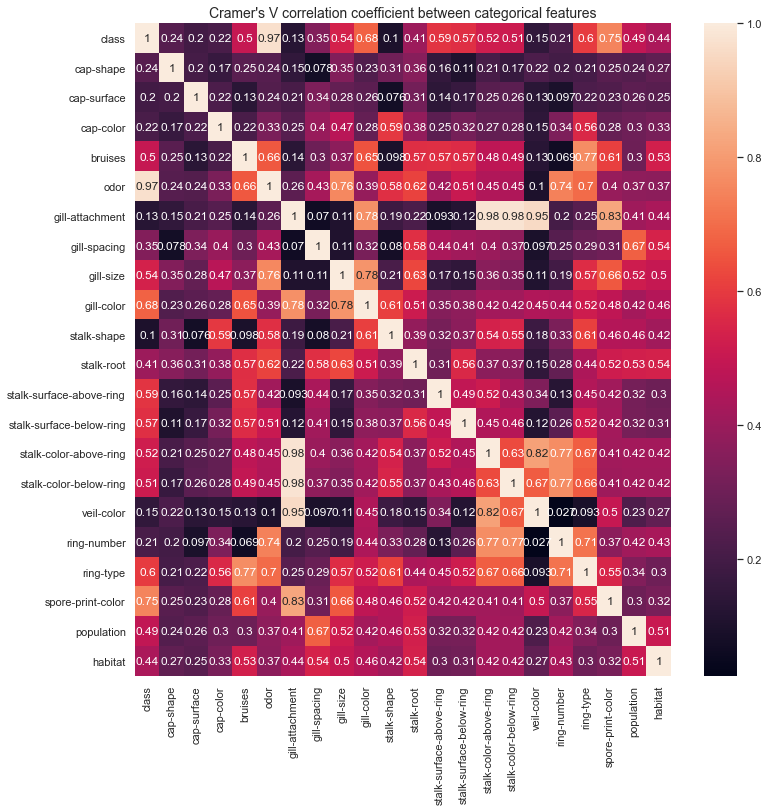

In [75]:
x = shrooms.drop('veil-type', axis=1)
corr_mat_cat = np.zeros((len(x.columns), len(x.columns)))
for i in range(len(x.columns)):
    for j in range(len(x.columns)):
        corr_mat_cat[i,j] = cramers_v(x.iloc[:,i], x.iloc[:,j])

plt.figure(figsize=(12,12))
sns.heatmap(corr_mat_cat, annot=True, xticklabels=x.columns, yticklabels=x.columns)
plt.title("Cramer's V correlation coefficient between categorical features", fontsize=14);

### This gives you a bird's eye view that class is well correlated with odor and spore peint color. As you can see the heatmap is symmetrical so we cannot really tell if odor predicts edible mushroom or if edible mushroom predicts the odor it would have. Enters Thail's U.

In [78]:
from collections import Counter
from scipy.stats import entropy
import math

def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

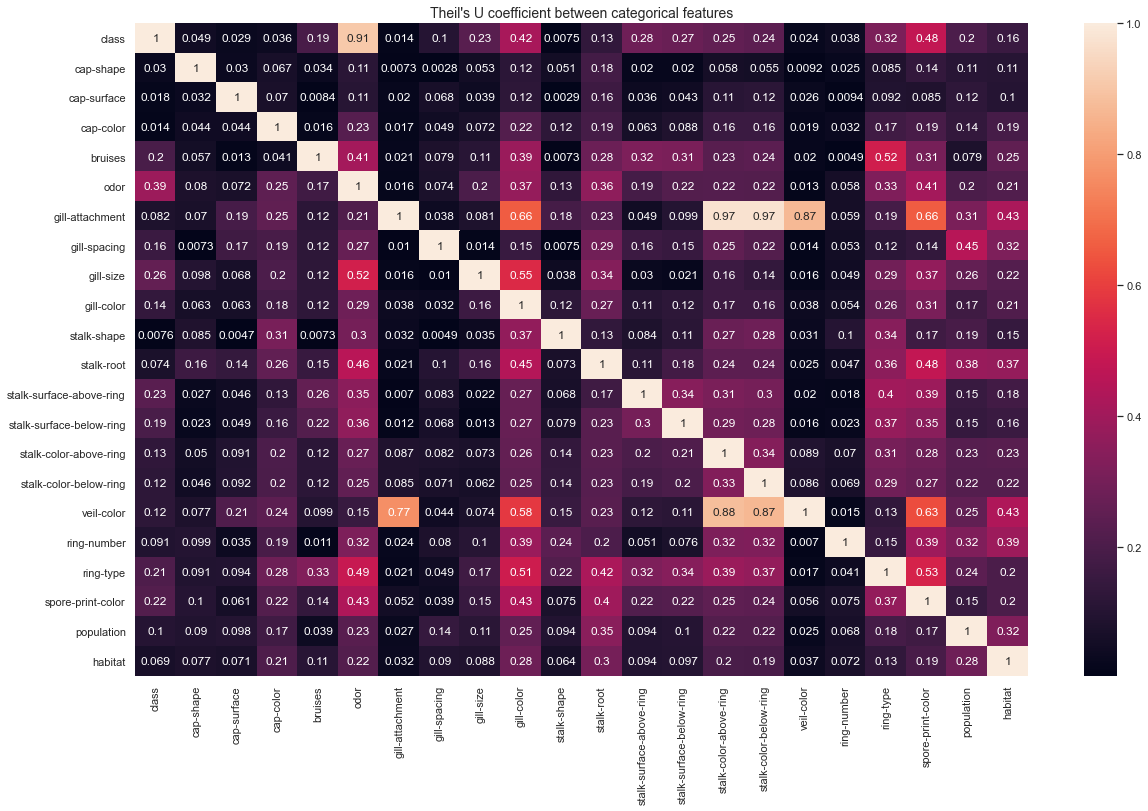

In [80]:
x = shrooms.drop('veil-type', axis=1)
corr_mat_cat = np.zeros((len(x.columns), len(x.columns)))
for i in range(len(x.columns)):
    for j in range(len(x.columns)):
        corr_mat_cat[i,j] = theils_u(x.iloc[:,i], x.iloc[:,j])

plt.figure(figsize=(20,12))
sns.heatmap(corr_mat_cat, annot=True, xticklabels=x.columns, yticklabels=x.columns)
plt.title("Theil's U coefficient between categorical features", fontsize=14);

## This is better, given odor we can predict the class reasonably well (Theil's U is 0.91), but not the other way around (given class, odor theil's U is 0.39.

In [83]:
def correlation_ratio(categories, measurements):
    """measure of the relationship between the statistical dispersion within individual 
    categories and the dispersion across the whole population or sample"""
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

# let's go back to the fish dataset for this one
numerical_cols = ['Weight', 'Length1', 'Length2', 'Length3', 'Height', 'Width']
for col in numerical_cols:
    eta = round(correlation_ratio(fish['Species'], fish[col]),3)
    print("Correlation ratio between {} and species is {}".format(col, eta))

Correlation ratio between Weight and species is 0.609
Correlation ratio between Length1 and species is 0.776
Correlation ratio between Length2 and species is 0.781
Correlation ratio between Length3 and species is 0.793
Correlation ratio between Height and species is 0.87
Correlation ratio between Width and species is 0.693


## Those are relatively high correlation ratios. In particular, given the height of the fish we can predict the species reasonably well, while weight provides the least separation between species.